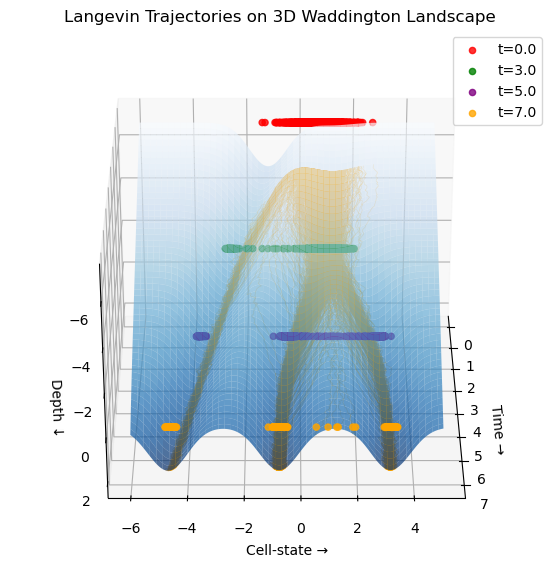

t=0.0: (1000,)
t=3.0: (1000,)
t=5.0: (1000,)
t=7.0: (1000,)


In [85]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Parameters (reuse last landscape) ---
'''
x_min, x_max = 0.0, 10.0
y_min, y_max = -4.0, 4.0
x1, x2 = 3.0, 7.0      
k = 0.3                
d = 1.2                
delta = 1.5            
sigma = 0.5            
depth = 2.0            
slope = 1.0            
tilt_strength = -2.0'''
x_min, x_max = 0.0, 7.0
y_min, y_max = -6.0, 5.0
x1, x2 = 3.0, 3.2 #4.0      # branch onset
k = 0.9                # smoothness
d = 1.2                # base separation
delta = 2 #1.5            # second split offset
sigma = 0.7            # valley width

depth = 2.0            # valley depth
'''
depthA = 2.0           # leftmost
depthB = 2.0           # middle
depthC = 4.0           # rightmost (deeper => lower potential)
'''
slope = 1.0            # slope
tilt_strength = -3.5 #-1.5   # left valley tilt

# --- Langevin parameters ---
D = 0.03           # diffusion coefficient (noise strength)
num_traj = 1000    # number of trajectories
x0 = 1.0          # start time
N_steps = 200
xs = np.linspace(x0, x_max, N_steps)
dt = xs[1] - xs[0]

# --- Landscape definition ---
def sigmoid(x): return 1.0 / (1 + np.exp(-x))
u1 = lambda x: sigmoid((x - x1) / k)
u2 = lambda x: sigmoid((x - x2) / k)

def centers(x):
    fA = -d + tilt_strength * (x / x_max)
    fB =  d - u2(x) * delta
    fC =  d + u2(x) * delta
    return fA, fB, fC

def dU_dy(x, y):
    fA, fB, fC = centers(x)
    gA = np.exp(-((y - fA)**2) / (2 * sigma**2))
    gB = np.exp(-((y - fB)**2) / (2 * sigma**2)) * u1(x)
    gC = np.exp(-((y - fC)**2) / (2 * sigma**2)) * u2(x)
    return depth * ((y - fA)/sigma**2 * gA +
                    (y - fB)/sigma**2 * gB +
                    (y - fC)/sigma**2 * gC)

# --- Initialize ---
fA0 = 0.7#0.5 #centers(x0)[0]
y = np.random.normal(loc=fA0, scale=0.6, size=num_traj)
Ys = np.zeros((num_traj, N_steps))
Ys[:, 0] = y

# --- Euler-Maruyama ---
for i in range(N_steps-1):
    x_curr = xs[i]
    grad = dU_dy(x_curr, y)
    noise = np.sqrt(2*D*dt) * np.random.randn(num_traj)
    y = y - grad * dt + noise
    Ys[:, i+1] = y

# --- Snapshots ---
times = [x_min, x1, x1 + 2, x_max ]
inds = [np.abs(xs - t).argmin() for t in times]
data_snap = {f"t={t}": Ys[:, idx] for t, idx in zip(times, inds)}

# --- Plotting 3D with trajectories ---
Xg, Yg = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
Zg = -(slope*(x_max-Xg) + 
       (-depth * (
           np.exp(-((Yg - ( -d + tilt_strength*(Xg/x_max) ))**2)/(2*sigma**2)) +
           u1(Xg)*np.exp(-((Yg - ( d - u2(Xg)*delta ))**2)/(2*sigma**2)) +
           u2(Xg)*np.exp(-((Yg - ( d + u2(Xg)*delta ))**2)/(2*sigma**2))
       )))

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Xg, Yg, Zg, cmap='Blues', edgecolor='none', alpha=0.7)

# plot sample trajectories
for i in range(num_traj):
    Z_traj = -(slope*(x_max-xs) + 
               (-depth * (
                   np.exp(-((Ys[i] - centers(xs)[0])**2)/(2*sigma**2)) +
                   u1(xs)*np.exp(-((Ys[i] - centers(xs)[1])**2)/(2*sigma**2)) +
                   u2(xs)*np.exp(-((Ys[i] - centers(xs)[2])**2)/(2*sigma**2))
               )))
    ax.plot(xs, Ys[i], Z_traj, color='orange', alpha=0.4, linewidth=0.5)

inds = [np.abs(xs - t).argmin() for t in times]
colors = ['red','green','purple','orange']

for t, idx, c in zip(times, inds, colors):
    z_plane = -(slope*(x_max - t))  # baseline plane at time t
    ax.scatter(np.full(num_traj, t), Ys[:,idx], np.full(num_traj, z_plane), 
               c=c, s=20, alpha=0.8, label=f"t={t}")

ax.set_xlabel("Time →")
ax.set_ylabel("Cell-state →")
ax.set_zlabel("Depth ↓")
ax.view_init(elev=30, azim=0)
ax.invert_zaxis()
ax.legend()
plt.title("Langevin Trajectories on 3D Waddington Landscape")
plt.show()

# Print snapshot shapes
for t, data in data_snap.items():
    print(f"{t}: {data.shape}")


In [86]:
p1 = np.sum((data_snap[f't={times[-1]}'] > -5) & (data_snap[f't={times[-1]}'] < -3)) / num_traj
p2 = np.sum((data_snap[f't={times[-1]}'] > -2) & (data_snap[f't={times[-1]}'] < 0.1)) / num_traj
p3 = np.sum((data_snap[f't={times[-1]}'] > 2) & (data_snap[f't={times[-1]}'] < 4)) / num_traj

In [87]:
p1

np.float64(0.068)

In [88]:
p2

np.float64(0.725)

In [89]:
p3

np.float64(0.201)

In [90]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float32


On device: cuda


In [91]:
data_snap

{'t=0.0': array([ 1.14059995e+00,  9.95580600e-01,  5.39724081e-01,  1.33919965e+00,
         1.66511030e+00,  1.12398882e+00,  9.72755208e-01, -1.27365973e-01,
        -3.79069205e-02, -3.31286428e-01,  1.46042532e+00,  1.38494085e+00,
         8.11054467e-02,  9.47434642e-01,  1.44496200e+00,  9.85868182e-01,
         8.14261084e-01,  8.08133924e-01,  1.06434297e+00,  6.48230499e-01,
         1.45465494e+00,  8.71022287e-01,  4.66234850e-01,  6.37662448e-01,
         7.59374320e-01,  1.00097917e+00,  1.22182093e+00,  2.65569658e-01,
         1.69344790e-01,  1.48222054e+00,  1.14596250e+00,  7.78961883e-01,
         4.69844979e-01,  4.31405571e-01,  7.15034827e-01,  9.01711914e-01,
         1.36870214e+00,  6.08039402e-01,  5.54978319e-01,  1.37218608e+00,
         6.37083647e-01,  1.07063114e+00,  1.56066939e+00,  1.12811950e+00,
         9.71369559e-02,  5.13076514e-01,  7.29309450e-01,  4.51657709e-01,
         9.55143475e-01,  7.04721798e-01,  5.32788566e-01,  1.01880092e+00,
   

In [92]:

C_factors_sequence = []

for i in range(len(times) - 1):
    tp1 = data_snap[f't={times[i]}']
    tp2 = data_snap[f't={times[i+1]}']
    _X1 = torch.from_numpy(tp1).type(torch.DoubleTensor).to(device)
    _X2 = torch.from_numpy(tp2).type(torch.DoubleTensor).to(device)
    C12 = (torch.abs(_X1[:, None] - _X2[None, :])).to(device) #torch.cdist(_X1, _X2).to(device)
    C12 = C12.to(dtype)
    I = torch.eye(C12.shape[1]).to(dtype).to(device)
    C_factors_sequence.append(( C12, I ))



Iteration: 0
Initial Wasserstein cost: 0.7824075222015381, GW-cost: 0, Total cost: 0.7824075222015381
Final Wasserstein cost: 0.7057695388793945, GW-cost: 0, Total cost: 0.7057695388793945


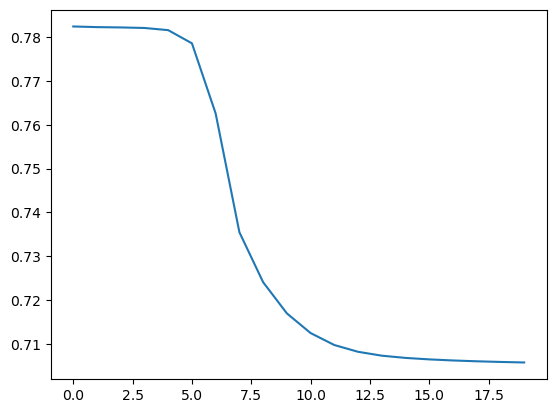

Iteration: 0
Initial Wasserstein cost: 1.694946527481079, GW-cost: 0, Total cost: 1.694946527481079
Final Wasserstein cost: 1.6901018619537354, GW-cost: 0, Total cost: 1.6901018619537354


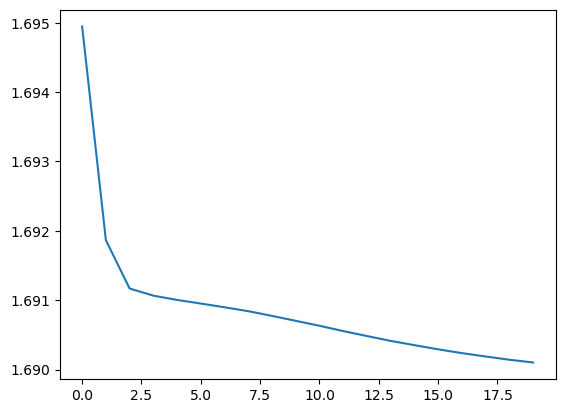

Iteration: 0
Initial Wasserstein cost: 1.7778992652893066, GW-cost: 0, Total cost: 1.7778992652893066
Final Wasserstein cost: 1.3132765293121338, GW-cost: 0, Total cost: 1.3132765293121338


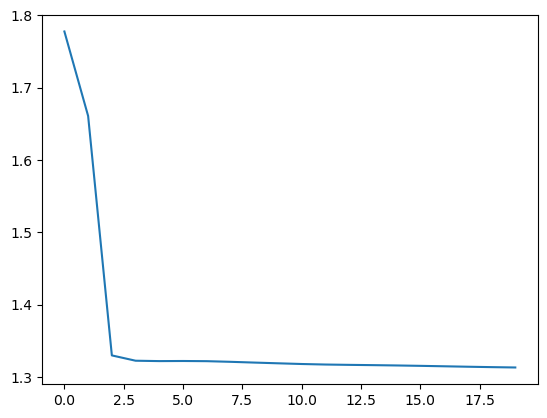

Iteration: 0
Initial Wasserstein cost: 1.4980705976486206, GW-cost: 0, Total cost: 1.4980705976486206
Final Wasserstein cost: 1.4921165704727173, GW-cost: 0, Total cost: 1.4921165704727173


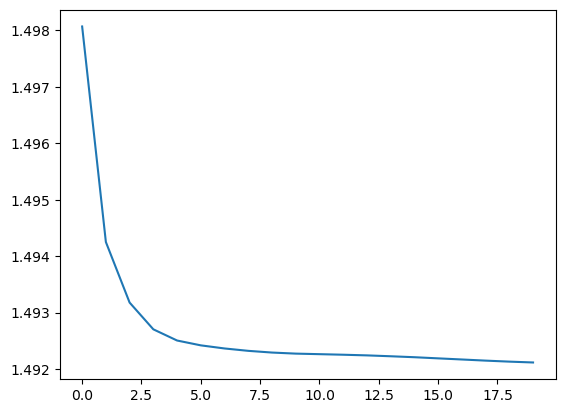

Iteration: 0
Initial Wasserstein cost: 0.7268352508544922, GW-cost: 0, Total cost: 0.7268352508544922
Final Wasserstein cost: 0.7116525173187256, GW-cost: 0, Total cost: 0.7116525173187256


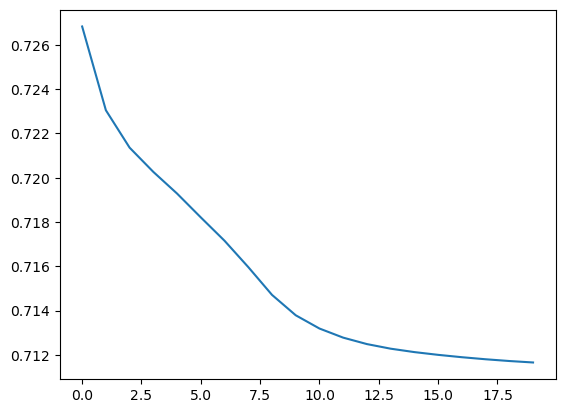

Ranks: r1 3, r2 3, r3 3
Iteration: 0
Initial Wasserstein-sum cost: 2.377251625061035
Final Wasserstein-sum cost: 2.2292261123657227


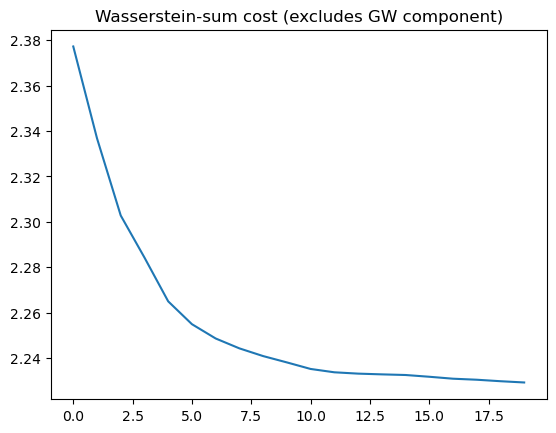

Ranks: r1 3, r2 3, r3 3
Iteration: 0
Initial Wasserstein-sum cost: 3.3886098861694336
Final Wasserstein-sum cost: 3.1834840774536133


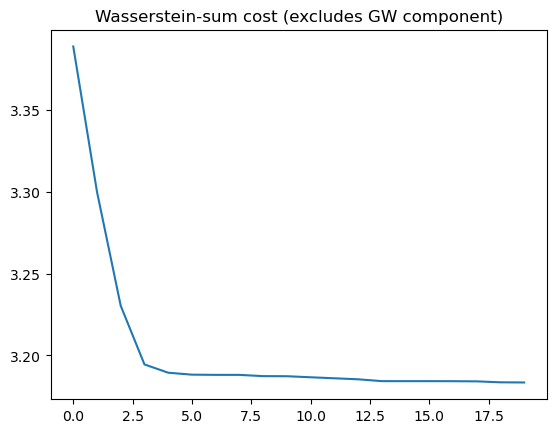

Iteration: 0
Initial Wasserstein cost: 0.7137119770050049, GW-cost: 0, Total cost: 0.7137119770050049
Final Wasserstein cost: 0.7127394676208496, GW-cost: 0, Total cost: 0.7127394676208496


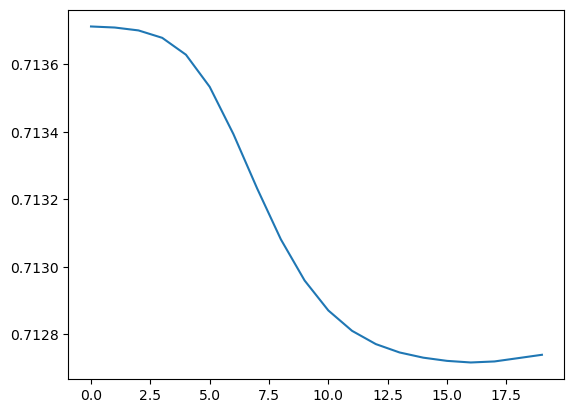

Iteration: 0
Initial Wasserstein cost: 1.5290718078613281, GW-cost: 0, Total cost: 1.5290718078613281
Final Wasserstein cost: 1.5290594100952148, GW-cost: 0, Total cost: 1.5290594100952148


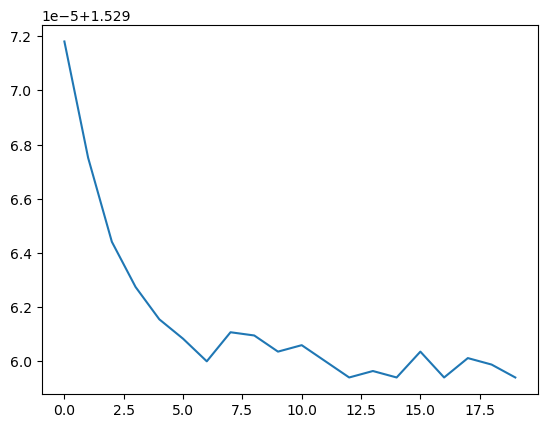

Iteration: 0
Initial Wasserstein cost: 1.677577018737793, GW-cost: 0, Total cost: 1.677577018737793
Final Wasserstein cost: 1.6775652170181274, GW-cost: 0, Total cost: 1.6775652170181274


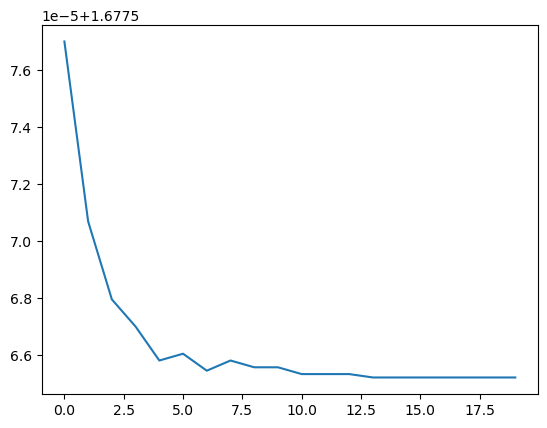

In [93]:
import sys
import os
sys.path.append(os.path.abspath(".."))
import src.HiddenMarkovOT as HiddenMarkovOT
import src.utils.clustering as clustering
import src.plotting as plotting
import importlib
importlib.reload(HiddenMarkovOT)

rank_list = [(3,3), (3,3), (3,3)]
iter = 20
gamma = 100.0
alpha = 0.0
tau_in = 100

# Rough guesstimate
# [p1, 1 - p1]
props = [
    torch.tensor([p1, p2, 1 - p1 - p2]).to(device).to(dtype),
    torch.tensor([p1, p2, 1 - p1 - p2]).to(device).to(dtype), 
    torch.tensor([p1, p2, 1 - p1 - p2]).to(device).to(dtype), 
    torch.tensor([p1, p2, 1 - p1 - p2]).to(device).to(dtype)
        ]

hmot = HiddenMarkovOT.HM_OT(rank_list = rank_list,
                            max_iter = iter,
                            min_iter = iter,
                            device=device,
                            alpha = alpha,
                            gamma = gamma,
                            dtype = dtype,
                            printCost = True,
                            returnFull = False,
                            initialization = 'Full',
                            tau_in = tau_in,
                            max_inner_iters_R = 300,
                            proportions = props
                            )

A_factors_sequence = [None] * (len(times))
hmot.gamma_smoothing(C_factors_sequence,
                    A_factors_sequence)


In [94]:
Qs = hmot.Q_gammas
Ts = hmot.T_gammas

Qs_np = [Q.cpu().detach().numpy() for Q in Qs]
Ts_np = [T.cpu().detach().numpy() for T in Ts]
#Qs_np = Qs_np[::-1]
#Ts_np = Ts_np[::-1]

Ss = [data_snap[f't={times[i]}'] for i in range(len(times))]

In [95]:

clustering_1 = clustering.reference_clustering(
                                Qs_np,
                                Ts_np,
                                reference_index=3)


In [96]:
clustering_1

[array([2, 2, 2, 2, 1, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 0, 0, 0, 2,
        2, 2, 0, 2, 0, 2, 1, 2, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 1, 2, 2,
        2, 0, 2, 2, 0, 0, 2, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2,
        0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 1, 0, 2, 2, 2, 0, 1,
        2, 0, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0,
        2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
        0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0,
        1, 0, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2, 2, 2, 0, 2, 2,
        0, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 0, 1, 0, 2, 2, 2, 0, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 0, 2, 0, 2, 2, 1, 2, 0, 0, 0, 0,
        2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 

/tmp/ipykernel_1799678/1565637668.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Snapshot Clusters")


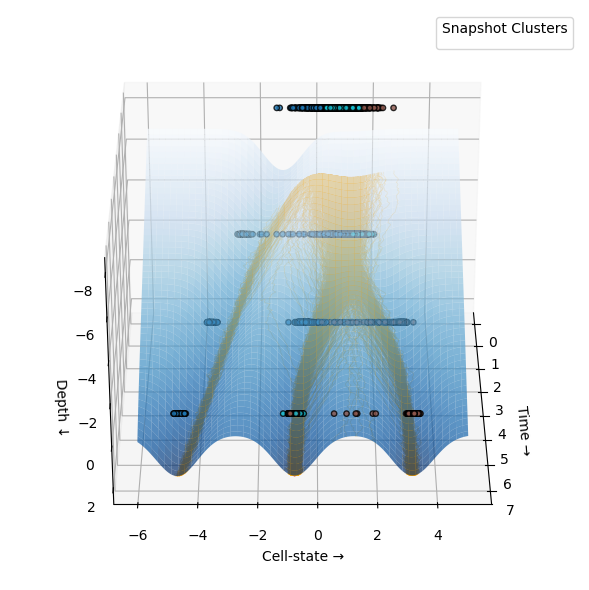

In [97]:
from mpl_toolkits.mplot3d import Axes3D

# --- Your existing data: Ys, xs, Xg, Yg, Zg, slope, x_max
# --- clustering_1 is your list of three np.arrays of labels

# Define the exact snapshot times you used
inds  = [ np.abs(xs - t).argmin() for t in times ]

fig = plt.figure(figsize=(12,6))
ax  = fig.add_subplot(111, projection='3d')

ax.plot_surface(Xg, Yg, Zg, cmap='Blues', edgecolor='none', alpha=0.7)

# plot sample trajectories
for i in range(num_traj):
    Z_traj = -(slope*(x_max-xs) + 
               (-depth * (
                   np.exp(-((Ys[i] - centers(xs)[0])**2)/(2*sigma**2)) +
                   u1(xs)*np.exp(-((Ys[i] - centers(xs)[1])**2)/(2*sigma**2)) +
                   u2(xs)*np.exp(-((Ys[i] - centers(xs)[2])**2)/(2*sigma**2))
               )))
    ax.plot(xs, Ys[i], Z_traj, color='orange', alpha=0.4, linewidth=0.5)

#ax.plot_surface(Xg, Yg, Zg, cmap='Blues', edgecolor='none', alpha=0.6)
eps = -1
# Overlay each snapshot, coloring by cluster label
for t, idx, labels in zip(times, inds, clustering_1):
    z_plane = -(slope * (x_max - t))
    ax.scatter(
        np.full_like(labels, t),
        Ys[:, idx],
        np.full_like(labels, z_plane+ eps),
        c=labels,
        cmap='tab10',
        s=15,
        edgecolor='k',
        alpha=0.8
    )

ax.set_xlabel("Time →")
ax.set_ylabel("Cell-state →")
ax.set_zlabel("Depth ↓")
ax.view_init(elev=30, azim=0)
ax.invert_zaxis()
ax.legend(title="Snapshot Clusters")
plt.tight_layout()
plt.show()

/tmp/ipykernel_1799678/1732826916.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Snapshot")


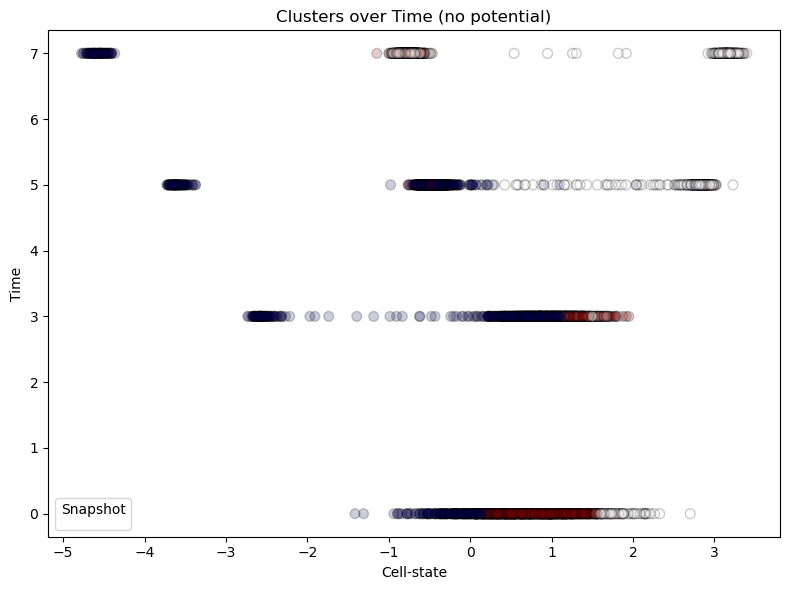

In [98]:
from mpl_toolkits.mplot3d import Axes3D

inds  = [np.abs(xs - t).argmin() for t in times]

fig, ax = plt.subplots(figsize=(8, 6))

for t, idx, labels in zip(times, inds, clustering_1):
    # cell‐state values at this time
    y_vals = Ys[:, idx]
    # create a constant array of the time
    t_vals = np.full_like(y_vals, t)
    # scatter: x=cell‐state, y=time, color=cluster
    sc = ax.scatter(
            y_vals,
            t_vals,
            c=labels,
            cmap='seismic',
            s=50,
            edgecolor='k',
            alpha=0.2
        )

ax.set_xlabel("Cell‐state")
ax.set_ylabel("Time")
ax.set_title("Clusters over Time (no potential)")
ax.legend(title="Snapshot")
plt.tight_layout()
plt.show()


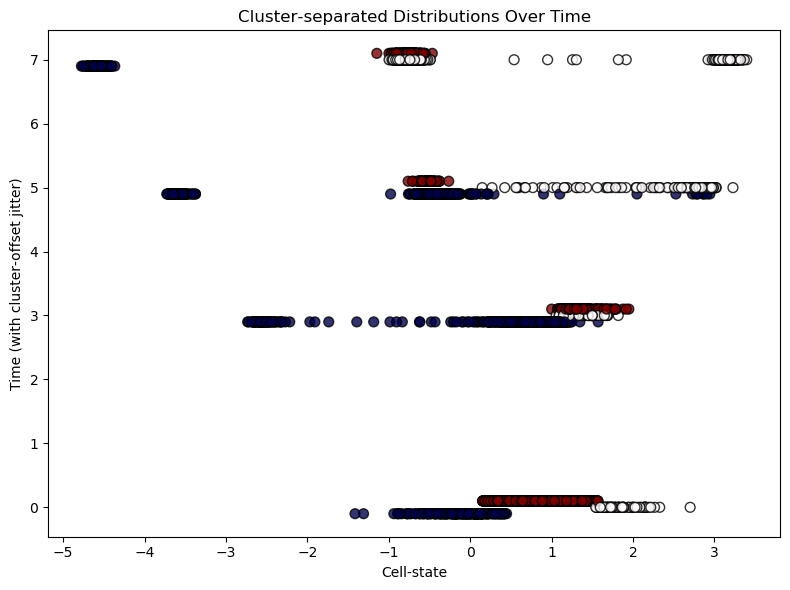

In [99]:


inds  = [np.abs(xs - t).argmin() for t in times]
K = max(max(cl) for cl in clustering_1) + 1    # number of clusters
eps = 0.1  # vertical offset step

fig, ax = plt.subplots(figsize=(8, 6))

for t, idx, labels in zip(times, inds, clustering_1):
    y_vals = Ys[:, idx]
    # center clusters around the timepoint t
    # labels in {0,1,...,K-1} → offsets in [-(K-1)/2*eps ... +(K-1)/2*eps]
    offsets = (labels - (K-1)/2) * eps
    t_vals = t + offsets
    ax.scatter(
        y_vals,
        t_vals,
        c=labels,
        cmap='seismic',
        s=50,
        edgecolor='k',
        alpha=0.8
    )

ax.set_xlabel("Cell‐state")
ax.set_ylabel("Time (with cluster‐offset jitter)")
ax.set_title("Cluster‐separated Distributions Over Time")
plt.tight_layout()
plt.show()
